<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [59]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

from mpmath import betainc   # integral de beta

from scipy.stats import bernoulli, beta   

from mpmath import betainc   # integral de beta

In [63]:
from bayes import *

In [61]:

def plote(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

In [4]:
# datos
cookies = pd.read_csv('./data/cookie_cats.csv')

cookies

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [5]:
# transformacion

cookies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [26]:
ret1d30=cookies.loc[(cookies['retention_1']==True) & (cookies['version']=='gate_30')][['userid','sum_gamerounds']].reset_index()
ret1d40=cookies.loc[(cookies['retention_1']==True) & (cookies['version']=='gate_40')][['userid','sum_gamerounds']].reset_index()

ret7d30=cookies.loc[(cookies['retention_7']==True) & (cookies['version']=='gate_30')][['userid','sum_gamerounds']].reset_index()
ret7d40=cookies.loc[(cookies['retention_7']==True) & (cookies['version']=='gate_40')][['userid','sum_gamerounds']].reset_index()


gate40=cookies.loc[(cookies['version']=='gate_40')][['userid','sum_gamerounds']].reset_index()
gate30=cookies.loc[(cookies['version']=='gate_30')][['userid','sum_gamerounds']].reset_index()

len(ret1d30)+ len(ret1d40)+ len(ret7d30)+ len(ret7d40)

56934

In [28]:
len(gate40)+len(gate30)

90189

In [29]:
# RETENTION 1 DIA

imps_ctrl, convs_ctrl= len(gate30), len(ret1d30)   # entrar, comprar
imps_test, convs_test= len(gate40), len(ret1d40)


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'


'TASAS: Control=0.4481879194630872, Test=0.44228274967574577'

In [79]:
# aprioris

a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_C=beta(a_C, b_C)
beta_T=beta(a_T, b_T)

In [89]:
prob=calc_prob(beta_C, beta_T)  # esta funcion es la clave

prob

0.9627939748515354

In [83]:
prob=beta.cdf(0.445, a_T, b_T)

prob=float(prob)

prob

0.8781293616836622

In [81]:
print (
'''El test aumenta la tasa de conversion en un {:2.2f}%,
con una probabilidad del {:2.2f}%'''
    .format(salto*100, prob*100))

El test aumenta la tasa de conversion en un -1.32%,
con una probabilidad del 3.72%


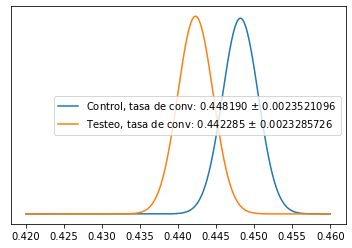

In [84]:
x=np.linspace(0.42, 0.46, 1000)

plote([beta_C, beta_T], ['Control', 'Testeo'])

In [85]:
salto=(beta_T.mean() - beta_C.mean())/beta_C.mean()

salto

-0.013175098158249857

In [86]:
prob=beta.cdf(0.445, a_T, b_T)

prob=float(prob)

prob

0.8781293616836622

RETENTION7

In [91]:
# testeo para retention_7
imps_ctrl, convs_ctrl= len(gate30), len(ret7d30)   # entrar, comprar
imps_test, convs_test= len(gate40), len(ret7d40)


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'




'TASAS: Control=0.19020134228187918, Test=0.18200004396667327'

In [92]:
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_C=beta(a_C, b_C)
beta_T=beta(a_T, b_T)

prob=calc_prob(beta_C, beta_T)  # esta funcion es la clave

salto=(beta_T.mean() - beta_C.mean())/beta_C.mean()

print (
'''El test aumenta la tasa de conversion en un {:2.2f}%,
con una probabilidad del {:2.2f}%'''
    .format(salto*100, prob*100))

El test aumenta la tasa de conversion en un -4.31%,
con una probabilidad del 99.92%


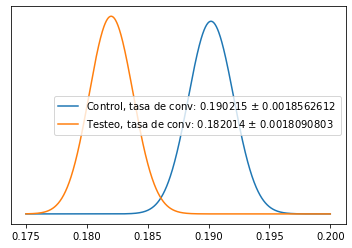

In [97]:
x=np.linspace(0.175, 0.2, 1000)

plote([beta_C, beta_T], ['Control', 'Testeo'])

In [ ]:
# conclusiones

#EN EL CASO DE 7 DÍAS: El test aumenta la tasa de conversion en un -4.31%, con una probabilidad del 99.92%. POR LO TANTO MEJOR QUEDARNOS CON LA PUERTA 30
#EN EL CASO DE 1 DÍA: El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 3.72%. POR LO TANTO MEJOR QUEDARNOS CON LA PUERTA 30